<a href="https://colab.research.google.com/github/timosachsenberg/EuBIC2026/blob/main/notebooks/EUBIC_Task1_Peaks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# Install dependencies (for Google Colab)
!pip install -q pyopenms>=3.5.0 pyopenms-viz>=1.0.0

# Notebook 1 – From Proteins to Spectra: Digestion & First Look at LC–MS Data

In this notebook we will:

1. **Get acquainted with `pyopenms` and enzymatic digestion**  
   - Load a small **FASTA file** (a text format for storing protein/nucleotide sequences) with a few protein sequences  
   - Perform an **in-silico** (computational, as opposed to in a wet lab) **Trypsin** digestion  
   - Generate realistic bottom-up **peptides** with length and missed-cleavage constraints  

2. **Take a first look at typical LC–MS data**  
   - Load an **mzML file** (an open XML format for mass spectrometry data)  
   - Visualize the data as a 2D **peak map (heatmap)**  
   - Extract and plot a **single MS1 spectrum**  

3. **Zoom into isotope patterns**  
   - Find an **isotope pattern** of an analyte  
   - Estimate the **charge state** and **mass** of the analyte  

4. **Compute the Total Ion Chromatogram (TIC)**  
   - Calculate the **TIC** as the sum of all ion intensities over time  
   - Interpret the axes and what the TIC tells us about the LC–MS run

---

<details>
<summary><b>Quick Reference: Key Terms Used in This Notebook</b></summary>

| Term | Definition | Example |
|------|------------|---------|
| **m/z** | Mass-to-charge ratio. The mass of an ion divided by its charge. | A peptide with mass 1000 Da and charge +2 has m/z = 500 |
| **RT** | Retention time - when an analyte elutes from the LC column (seconds) | RT = 1200 s means the peptide eluted at 20 minutes |
| **MS1** | Survey scan measuring intact peptide masses | Used to detect which peptides are present |
| **Isotope pattern** | Group of peaks from the same molecule with different isotopes | Peaks spaced ~0.5 m/z apart for a +2 ion |
| **TIC** | Total Ion Chromatogram - sum of all ion intensities at each time point | Shows when analytes elute |
| **FASTA** | Text file format for protein/DNA sequences | Each entry has a header (>) and sequence |
| **mzML** | Standard XML format for mass spectrometry data | Contains spectra with m/z and intensity arrays |
| **Da (Dalton)** | Unit of molecular mass (same as unified atomic mass unit, u) | Alanine residue = ~71 Da |

</details>

<details>
<summary><b>Common Errors and How to Fix Them</b></summary>

**1. FileNotFoundError: FASTA or mzML file not found**
```python
# Error: FileNotFoundError: [Errno 2] No such file or directory: 'two_ups_proteins.fasta'
```
**Cause**: The data file wasn't downloaded or the path is wrong.

**Fix**: Make sure the download cell ran successfully:
```python
import os
print(os.listdir("."))  # Check what files exist
```

---

**2. ModuleNotFoundError: No module named 'pyopenms'**
```python
# Error: ModuleNotFoundError: No module named 'pyopenms'
```
**Fix**: Install the package:
```python
!pip install pyopenms>=3.5.0
```

---

**3. Empty spectrum (no peaks)**
```python
# mzs and intensities arrays are empty
```
**Cause**: The spectrum index might be out of range or the file is corrupted.

**Fix**:
- Check the number of spectra: `print(exp.size())`
- Try a different spectrum index: `MS1_spectrum = exp[10]`
- Verify it's MS1: `print(MS1_spectrum.getMSLevel())`

---

**4. Plot not showing in Jupyter**

**Cause**: matplotlib inline magic not set.

**Fix**: Add this at the top of your notebook:
```python
%matplotlib inline
```

---

**5. Interactive plot not displaying (pyopenms-viz)**

**Cause**: Plotly renderer not configured for your environment.

**Fix for Jupyter**:
```python
import plotly.io as pio
pio.renderers.default = "notebook"  # or "jupyterlab" or "colab"
```

---

**6. NameError: name 'entries' is not defined**

**Cause**: You skipped the cell that loads the FASTA file.

**Fix**: Run all cells in order from the top, or re-run the FASTA loading cell.

</details>

In [15]:
%matplotlib inline
import pyopenms as oms
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
print("pyOpenMS version:", oms.__version__)

pyOpenMS version: 3.5.0


## 1. Enzymatic digestion with Trypsin (in-silico)

**Aim of this task**

We want to get familiar with `pyopenms` and simulate a simple **bottom-up proteomics** scenario:

- We start from a small **FASTA file** containing two human proteins from the UPS1 standard (Complement C5 and Pro-epidermal growth factor).
- We apply a **Trypsin** digestion:
  - Trypsin cleaves **after K (Lys) and R (Arg)**, except when followed by **P (Proline)**.
- We allow up to **2 missed cleavages**, because the enzyme is not perfect.
- We only keep peptides with length between **7 and 40 amino acids**, so that they are realistic for LC–MS/MS.

At the end, we will:
- Print the protein entries from the FASTA file
- Generate in-silico peptides for each protein
- Count and print the **total number of peptides**.

<details>
<summary><b>New to Python? Understanding the Code Patterns</b></summary>

This notebook uses several Python patterns you'll see repeatedly:

**1. Loading data into objects:**
```python
fasta = oms.FASTAFile()      # Create an empty container object
entries = []                  # Create an empty list to store results
fasta.load("file.fasta", entries)  # Load fills the list with data
```

**2. Iterating over collections:**
```python
for entry in entries:         # Loop through each item
    print(entry.identifier)   # Access properties with dot notation
```

**3. List operations:**
```python
peptides = []                 # Empty list
peptides[:5]                  # First 5 items (slicing)
len(peptides)                 # Count items
```

**4. f-strings for formatting:**
```python
print(f"Found {len(peptides)} peptides")  # Variables inside {}
```

</details>

<details>
<summary><b>Deep Dive: Why Does Trypsin Cleave After K and R?</b></summary>

**The Biochemistry Behind Trypsin Specificity**

Trypsin is a serine protease with a negatively charged binding pocket (aspartate residue at position 189). This pocket attracts the positively charged side chains of:

- **Lysine (K)**: Has a positively charged amino group (-NH3+)
- **Arginine (R)**: Has a positively charged guanidinium group

```
Trypsin cleavage sites:

    ...Ala─Lys─┃─Glu...     Cleaves after Lys (K)
              ↓
    ...Ala─Arg─┃─Asp...     Cleaves after Arg (R)
              ↓
    ...Ala─Lys─╳─Pro...     Does NOT cleave before Pro (P)
```

**Why not before Proline?**

Proline's cyclic structure creates a rigid kink in the peptide backbone that prevents proper positioning in trypsin's active site. This is called the "proline rule."

**Why is this useful for proteomics?**

Tryptic peptides have predictable properties:
- End with K or R → good for MS/MS fragmentation
- Average length ~10-15 amino acids → ideal for LC-MS
- Generate charge states +2 to +4 → optimal for detection

</details>

In [16]:
# Download the FASTA file from the course repository (2 human UPS proteins)
import os
if not os.path.exists("two_ups_proteins.fasta"):
    !wget -q -O "two_ups_proteins.fasta" https://raw.githubusercontent.com/timosachsenberg/EuBIC2026/main/data/two_ups_proteins.fasta

fasta = oms.FASTAFile()
entries = []
fasta.load("two_ups_proteins.fasta", entries)

print(f"Loaded {len(entries)} FASTA entries\n")

for i, entry in enumerate(entries):
    print(f"Entry {i}")
    print("  ID:     ", entry.identifier)
    print("  Desc:   ", entry.description)
    print("  Length: ", len(entry.sequence), "aa")
    print("  Seq (first 60 aa):", entry.sequence[:60], "...\n")

Loaded 2 FASTA entries

Entry 0
  ID:      sp|P01031|CO5_HUMAN
  Desc:    Complement C5 OS=Homo sapiens OX=9606 GN=C5 PE=1 SV=4
  Length:  1676 aa
  Seq (first 60 aa): MGLLGILCFLIFLGKTWGQEQTYVISAPKIFRVGASENIVIQVYGYTEAFDATISIKSYP ...

Entry 1
  ID:      sp|P01133|EGF_HUMAN
  Desc:    Pro-epidermal growth factor OS=Homo sapiens OX=9606 GN=EGF PE=1 SV=2
  Length:  1207 aa
  Seq (first 60 aa): MLLTLIILLPVVSKFSFVSLSAPQHWSCPEGTLAGNGNSTCVGPAPFLIFSHGNSIFRID ...



<details>
<summary><b>pyOpenMS Reference: FASTAFile</b></summary>

| Class/Method | Purpose | Documentation |
|--------------|---------|---------------|
| `FASTAFile()` | Class for reading/writing FASTA files | [FASTAFile docs](https://pyopenms.readthedocs.io/en/latest/apidoc/pyopenms.html#pyopenms.FASTAFile) |
| `.load(path, entries)` | Load FASTA file into a list of entries | Each entry has `.identifier`, `.description`, `.sequence` |
| `.store(path, entries)` | Write entries to a FASTA file | |

**FASTAEntry attributes:**
```python
entry.identifier   # Protein accession (e.g., "sp|P01031|CO5_HUMAN")
entry.description  # Full header line description
entry.sequence     # Amino acid sequence as string
```

**Example:**
```python
fasta = oms.FASTAFile()
entries = []
fasta.load("proteins.fasta", entries)
for entry in entries:
    print(f"{entry.identifier}: {len(entry.sequence)} amino acids")
```

</details>

Typically we only observe peptides of a certain size (about 7–40 amino acids) reliably. Very small ones are ambiguous and unstable; very large ones don’t ionize or fragment well.

In practice, proteolytic enzymes do not cleave perfectly. These missed cleavages produce longer peptides that still contain internal cleavage sites. Explore how allowing missed cleavages increases the number of generated peptides.

Accounting for both missed cleavages and length restrictions will generate realistic peptide sequences that we could in principle measure by mass spectrometry.

<details>
<summary><b>pyOpenMS Reference: ProteaseDigestion & AASequence</b></summary>

| Class/Method | Purpose | Documentation |
|--------------|---------|---------------|
| `ProteaseDigestion()` | Configure and perform enzymatic digestion | [ProteaseDigestion docs](https://pyopenms.readthedocs.io/en/latest/apidoc/pyopenms.html#pyopenms.ProteaseDigestion) |
| `.setEnzyme(name)` | Set protease (e.g., "Trypsin", "Chymotrypsin", "Lys-C") | [Available enzymes](https://pyopenms.readthedocs.io/en/latest/user_guide/peptides_proteins.html#enzymes) |
| `.setMissedCleavages(n)` | Allow up to n missed cleavage sites | |
| `.digest(protein, peptides, min_len, max_len)` | Perform digestion, store results in peptides list | |
| `AASequence(string)` | Create amino acid sequence from string | [AASequence docs](https://pyopenms.readthedocs.io/en/latest/apidoc/pyopenms.html#pyopenms.AASequence) |
| `.toString()` | Get sequence as string | |
| `.size()` | Get number of amino acids | |
| `.getMonoWeight()` | Get monoisotopic mass | |

**Example:**
```python
# Configure digestion
dig = oms.ProteaseDigestion()
dig.setEnzyme("Trypsin")
dig.setMissedCleavages(2)

# Digest a protein
protein = oms.AASequence("MKWVTFISLLLLFSSAYSRGVFRR")
peptides = []
dig.digest(protein, peptides, 6, 30)  # min/max peptide length

for pep in peptides:
    print(f"{pep.toString()}: {pep.getMonoWeight():.2f} Da")
```

See also: [Peptides and Proteins Tutorial](https://pyopenms.readthedocs.io/en/latest/user_guide/peptides_proteins.html)

</details>

In [17]:
# Create a ProteaseDigestion object and configure Trypsin
digestion = oms.ProteaseDigestion()
digestion.setEnzyme("Trypsin")       # use Trypsin
digestion.setMissedCleavages(2)     # here allow up to 2 missed cleavages

# min and max length of peptide allow
min_len = 7
max_len = 40

# iterate over entries in fasta
for entry in entries:
    protein_seq = oms.AASequence(entry.sequence)  # convert to AASequence object
    peptides = [] # empty list to store digested peptides list
    digestion.digest(protein_seq, peptides, min_len, max_len) # do the digestion

    print("\nNumber of in-silico peptides of protein", entry.identifier, ":", len(peptides))

    # Show a few example peptides
    print("\nExample peptides:")
    for pep in peptides[:5]:
      print(f"    {pep.toString()} (length {pep.size()})")


Number of in-silico peptides of protein sp|P01031|CO5_HUMAN : 345

Example peptides:
    MGLLGILCFLIFLGK (length 15)
    TWGQEQTYVISAPK (length 14)
    VGASENIVIQVYGYTEAFDATISIK (length 25)
    FSYSSGHVHLSSENK (length 15)
    FQNSAILTIQPK (length 12)

Number of in-silico peptides of protein sp|P01133|EGF_HUMAN : 216

Example peptides:
    MLLTLIILLPVVSK (length 14)
    IDTEGTNYEQLVVDAGVSVIMDFHYNEK (length 28)
    IYWVDLER (length 8)
    VFLNGSR (length 7)
    NVSGMAINWINEEVIWSNQQEGIITVTDMK (length 30)


---
### Exercise 1: Explore Missed Cleavages

**Predict first, then verify!** This is how scientists think.

1. **Prediction**: If we change `setMissedCleavages` from 2 to 0, will we get MORE or FEWER peptides?
2. **Why?** Write down your reasoning before running the code.
3. **Verify**: Run the cell below to see how missed cleavages affect peptide count.

<details>
<summary><b>Click to reveal the answer</b></summary>

**Answer**: FEWER peptides.

With 0 missed cleavages, we only get peptides from "perfect" cleavage - every K and R is cut. With 2 missed cleavages, we also get peptides that span 1 or 2 cleavage sites.

**Example**: The sequence `LAEQAERYDDMASAMK` contains one internal K.
- With 0 missed cleavages: `LAEQAER` and `YDDMASAMK` (2 peptides)
- With 1 missed cleavage: Also `LAEQAERYDDMASAMK` (3 peptides total)

Typical results for these 2 UPS proteins:
- 0 missed cleavages: ~74 peptides per protein
- 1 missed cleavage: ~182 peptides per protein  
- 2 missed cleavages: ~280 peptides per protein

The number increases dramatically because each additional missed cleavage creates many new possible peptide variants!

</details>

---

In [18]:
# Exercise 1: Experiment with missed cleavages
# Run this cell to see how missed cleavages affect peptide count

for mc in [0, 1, 2, 3]:
    digestion_test = oms.ProteaseDigestion()
    digestion_test.setEnzyme("Trypsin")
    digestion_test.setMissedCleavages(mc)

    total_peptides = 0
    for entry in entries:
        protein_seq = oms.AASequence(entry.sequence)
        peptides_test = []
        digestion_test.digest(protein_seq, peptides_test, min_len, max_len)
        total_peptides += len(peptides_test)

    print(f"Missed cleavages {mc}: {total_peptides} peptides ({total_peptides/len(entries):.0f} per protein)")

Missed cleavages 0: 148 peptides (74 per protein)
Missed cleavages 1: 365 peptides (182 per protein)
Missed cleavages 2: 561 peptides (280 per protein)
Missed cleavages 3: 697 peptides (348 per protein)


<details>
<summary><b>pyOpenMS Reference: MSExperiment & MzMLFile</b></summary>

| Class/Method | Purpose | Documentation |
|--------------|---------|---------------|
| `MSExperiment()` | Container for mass spectrometry data (spectra) | [MSExperiment docs](https://pyopenms.readthedocs.io/en/latest/apidoc/pyopenms.html#pyopenms.MSExperiment) |
| `MzMLFile()` | Read/write mzML format files | [MzMLFile docs](https://pyopenms.readthedocs.io/en/latest/apidoc/pyopenms.html#pyopenms.MzMLFile) |
| `.load(path, exp)` | Load mzML file into MSExperiment | |
| `.store(path, exp)` | Write MSExperiment to mzML file | |
| `exp.size()` | Number of spectra in experiment | |
| `exp[i]` | Access spectrum by index | Returns `MSSpectrum` |
| `exp.updateRanges()` | Update m/z and intensity ranges | Required before `getMinIntensity()`, etc. |
| `exp.getMinIntensity()` / `getMaxIntensity()` | Get intensity range | |

**MSSpectrum methods:**
```python
spec = exp[0]
spec.getRT()           # Retention time in seconds
spec.getMSLevel()      # MS level (1 or 2)
spec.get_peaks()       # Returns (mz_array, intensity_array)
spec.getPrecursors()   # Precursor info (MS2 only)
```

**Example:**
```python
exp = oms.MSExperiment()
oms.MzMLFile().load("data.mzML", exp)

for spec in exp:
    if spec.getMSLevel() == 1:
        mzs, intensities = spec.get_peaks()
        print(f"RT {spec.getRT():.1f}s: {len(mzs)} peaks")
```

See also: [MS Data Tutorial](https://pyopenms.readthedocs.io/en/latest/user_guide/ms_data.html)

</details>

## 2. First look at MS1 data: peak map and single spectrum

**Aim of this task**

We now want to look at **real mass spectrometry data**.

- We load an mzML file containing **MS1 spectra**.
- We visualize the data as a 2D **peak map**:
  - **x-axis**: mass-to-charge ratio (**m/z**)
  - **y-axis**: retention time (RT, usually in seconds or minutes)
  - **color**: signal **intensity** at that m/z–RT position

This helps us get a global overview of the LC–MS run.

Then:

- We extract **one single MS1 spectrum**.
- We plot this spectrum as **intensity vs. m/z**.
- This allows us to see how a single snapshot of the LC–MS run looks like.

In [19]:
# Download the mzML file from the course repository (5-minute subset of UPS1 data)
import os
if not os.path.exists("UPS1_5min.mzML"):
    !wget -q -O "UPS1_5min.mzML" https://raw.githubusercontent.com/timosachsenberg/EuBIC2026/main/data/UPS1_5min.mzML

# initialize MSExperiment object for 1D peak data
exp = oms.MSExperiment()
oms.MzMLFile().load("UPS1_5min.mzML", exp)
print(f"Loaded {exp.size()} spectra")

Loaded 2043 spectra


<details>
<summary><b>pyOpenMS Reference: Working with Spectra</b></summary>

| Class/Method | Purpose | Example |
|--------------|---------|---------|
| `MSExperiment` | Container for all spectra | `exp = oms.MSExperiment()` |
| `MzMLFile().load()` | Load mzML file | `oms.MzMLFile().load("file.mzML", exp)` |
| `exp.size()` | Number of spectra | `print(f"Loaded {exp.size()} spectra")` |
| `exp[i]` | Access spectrum by index | `spec = exp[0]` |
| `spec.getRT()` | Retention time (seconds) | `rt = spec.getRT()` |
| `spec.getMSLevel()` | MS level (1 or 2) | `if spec.getMSLevel() == 1:` |
| `spec.get_peaks()` | Extract m/z and intensity arrays | `mzs, ints = spec.get_peaks()` |
| `spec.getPrecursors()` | Precursor info (MS2 only) | `prec = spec.getPrecursors()[0]` |

**Iterating over spectra:**
```python
for spec in exp:
    if spec.getMSLevel() == 1:
        mzs, ints = spec.get_peaks()
        # process MS1 spectrum
```

</details>

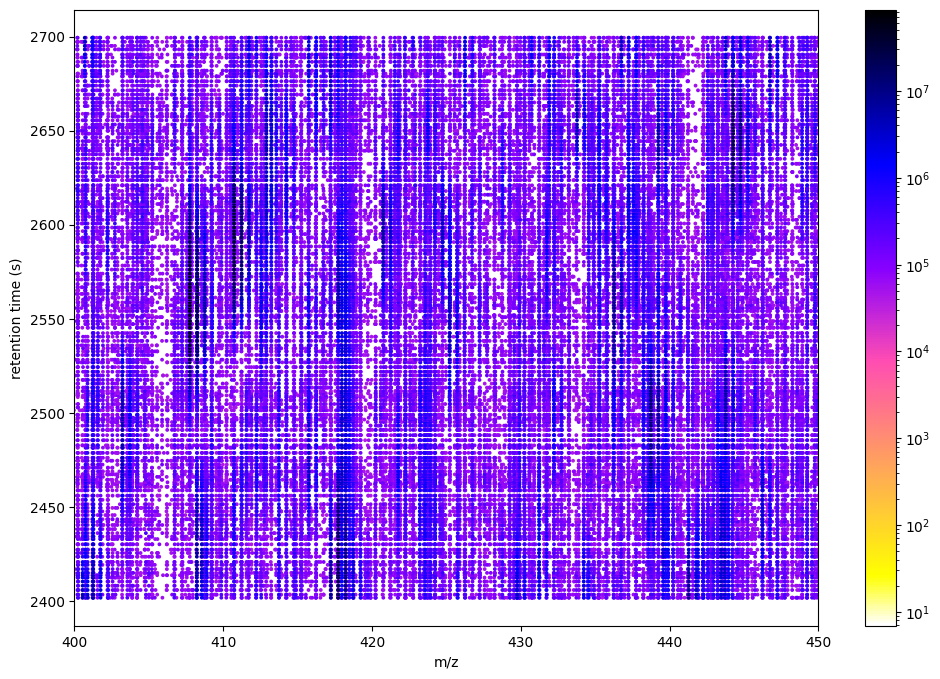

In [33]:
# checkout pyOpenMS tutorial https://pyopenms.readthedocs.io/en/latest/user_guide/ms_data.html
def plot_spectra_2D(exp, ms_level=1, marker_size=3):
    fig = plt.figure(figsize=(12,8))
    exp.updateRanges()
    # extract each spectra from experiment
    for spec in exp:
        if spec.getMSLevel() == ms_level: # just take MS1 spectras
            mz, intensity = spec.get_peaks() # get peaks: mz corrsponding intensity
            p = intensity.argsort()  # sort by intensity to plot highest on top
            rt = np.full([mz.shape[0]], spec.getRT(), float) #Each spectrum has a single RT, but many m/z points, you broadcast the RT to match the length of the m/z array.
            plt.scatter(
                mz[p],
                rt,
                c=intensity[p],
                s=marker_size,
                cmap="gnuplot2_r",  # <- the color palette
                norm=colors.Normalize(
                    exp.getMinIntensity() + 1, exp.getMaxIntensity()
                ),
            )
    plt.clim(exp.getMinIntensity() + 1, exp.getMaxIntensity())
    plt.xlim(400, 450) # plot some small region
    plt.xlabel("m/z")
    plt.ylabel("retention time (s)")
    plt.colorbar()
    plt.show()  # slow for larger data sets

# plot the spectra 2D
plot_spectra_2D(exp)

## 2.1 Plotting a single MS1 spectrum

Now we zoom into a **single MS1 spectrum**.

- A spectrum is a set of **peaks** measured at one retention time:
  - Each peak has an m/z value and an intensity.
- We plot **intensity vs. m/z**.

Tasks:

- Choose an MS1 spectrum index.
- Extract its m/z and intensity arrays via `get_peaks()`.
- Plot the spectrum as a stem plot.
- Clearly label axes:
  - x-axis: m/z
  - y-axis: intensity

optional: plot the spectrum with `pyopenms-viz` using `plot_spectrum`

<details>
<summary><b>pyOpenMS Reference: pyopenms-viz Spectrum Plotting</b></summary>

| Method | Purpose | Documentation |
|--------|---------|---------------|
| `import pyopenms_viz` | Register ms_plotly backend for pandas | [pyopenms-viz docs](https://pyopenms-viz.readthedocs.io/) |
| `df.plot(kind='spectrum', ...)` | Plot spectrum from DataFrame | |
| `backend='ms_plotly'` | Use interactive Plotly rendering | |

**Required DataFrame columns:**
- `mz`: mass-to-charge values
- `intensity`: signal intensities

**Common parameters:**
```python
df.plot(
    kind='spectrum',
    x='mz',                    # Column for x-axis
    y='intensity',             # Column for y-axis
    backend='ms_plotly',       # Use Plotly backend
    width=900,                 # Plot width in pixels
    height=400,                # Plot height in pixels
    title='My Spectrum'        # Plot title
)
```

**Convert MSSpectrum to DataFrame:**
```python
mzs, intensities = spectrum.get_peaks()
spectrum_df = pd.DataFrame({'mz': mzs, 'intensity': intensities})
```

See also: [pyopenms-viz Documentation](https://pyopenms-viz.readthedocs.io/)

</details>

In [21]:
# Take one mass spectrum from provided experiment data
MS1_spectrum = exp[0]  # By modifying the number, you can access the other spectrums
print("check spectrum level: ", MS1_spectrum.getMSLevel())

check spectrum level:  2


In [22]:
# plot it with pyopenms-viz
# pyopenms-viz extends pandas DataFrame plotting
import pandas as pd
import pyopenms_viz  # registers the plotting backend

# convert spectrum to DataFrame using get_peaks()
mzs, intensities = MS1_spectrum.get_peaks()
spectrum_df = pd.DataFrame({'mz': mzs, 'intensity': intensities})
spectrum_df.plot(kind='spectrum', x='mz', y='intensity', backend='ms_plotly', width=900, height=400);

## 3. Isotope patterns: estimate charge and mass

In high-resolution MS1 spectra, analytes often appear as **isotope patterns**:

- Several peaks with the **same charge** but slightly different m/z values.
- The spacing between peaks is approximately **1 / z** m/z units, where *z* is the charge. Corresponding to an additional neutron.

We will:

1. **Zoom into a small m/z region** of one MS1 spectrum to visually find an isotope pattern.  
2. Visually measure the spacing between isotopic peaks to estimate the **charge z**.  
3. Estimate the **neutral mass** of the analyte:

m_neutral ≈ (m/z) * z - z * m_p


where \( m_p \) is the proton mass (~1.0073 Da).

<details>
<summary><b>Deep Dive: Why Do Isotope Patterns Exist?</b></summary>

**The Physics Behind Isotope Patterns**

Most elements have multiple stable isotopes with different numbers of neutrons:

| Element | Most abundant | Less abundant | Natural abundance |
|---------|--------------|---------------|-------------------|
| Carbon | 12C (6p, 6n) | 13C (6p, 7n) | 98.9% / 1.1% |
| Nitrogen | 14N | 15N | 99.6% / 0.4% |
| Oxygen | 16O | 17O, 18O | 99.8% / 0.04% / 0.2% |
| Sulfur | 32S | 33S, 34S | 95% / 0.8% / 4.2% |

**For a peptide with ~50 carbon atoms:**
- ~50% of molecules have all 12C (monoisotopic)
- ~35% have one 13C
- ~12% have two 13C
- etc.

**Isotope distribution example:**

![Isotope Distribution](https://raw.githubusercontent.com/timosachsenberg/EuBIC2026/main/notebooks/images/DFPIANGER_isoDistribution.png)

*Image: Theoretical isotope distribution for the peptide DFPIANGER. The monoisotopic peak (M) is followed by M+1, M+2, etc. Source: [pyOpenMS Documentation](https://pyopenms.readthedocs.io/).*

**The Key Insight**: The spacing between isotope peaks in m/z directly tells you the charge state!
- Spacing = 1.0 m/z → charge = +1
- Spacing = 0.5 m/z → charge = +2
- Spacing = 0.33 m/z → charge = +3
- General formula: **charge = 1 / spacing**

</details>

In [23]:
# with pyopenms-viz - use interactive zoom to explore isotope patterns
import pandas as pd
import pyopenms_viz  # registers the plotting backend

# convert spectrum to DataFrame using get_peaks()
mzs, intensities = MS1_spectrum.get_peaks()
spectrum_df = pd.DataFrame({'mz': mzs, 'intensity': intensities})

# plot the full spectrum - zoom into 586-588 m/z to see the isotope pattern
spectrum_df.plot(kind='spectrum', x='mz', y='intensity', backend='ms_plotly',
                 width=900, height=400, title='Zoom into 586–588 m/z to see isotope pattern');

We can see a clear isotope pattern. The peak at ~586.34 m/z is the lightest peak in the pattern and likely the monoisotopic peak. The next peak (to the right) at ~586.84 m/z corresponds to the molecule with one additional neutron in one of its atoms. We don't know which atom in each molecule has the additional neutron—it could be any. This means that the many ions recorded to form this isotopic peak are likely a mixture of many isotopic variants of the molecule, each with an additional neutron.

The spacing between the isotopic peaks is ~0.5 m/z. We know that a neutron adds ~1.0 Da (or u). If we observe a spacing of 0.5 m/z, it tells us that the charge z of the ion is +2.

---

### Exercise 3: Calculate Charge State and Neutral Mass

Using the isotope pattern at 586-588 m/z, complete these calculations:

**Part A: Determine the charge state**
1. The monoisotopic peak is at ~586.34 m/z
2. The next isotope peak (M+1) is at ~586.84 m/z  
3. What is the spacing? What charge state does this indicate?

**Part B: Calculate the neutral mass**

Use the formula: `neutral_mass = (m/z × charge) - (charge × 1.0073)`

where 1.0073 Da is the mass of a proton.

<details>
<summary><b>Click to check your answers</b></summary>

**Part A: Charge State**
```
Spacing = 586.84 - 586.34 = 0.50 m/z
Charge = 1 / spacing = 1 / 0.50 = 2
```
The ion has a **+2 charge state**.

**Part B: Neutral Mass**
```python
mz = 586.34
charge = 2
proton_mass = 1.0073

neutral_mass = (mz * charge) - (charge * proton_mass)
neutral_mass = (586.34 * 2) - (2 * 1.0073)
neutral_mass = 1172.68 - 2.0146
neutral_mass = 1170.7 Da
```

The neutral (uncharged) mass of this peptide is approximately **1170.7 Da**.

</details>

---

In [24]:
# Exercise 3: Calculate charge state and neutral mass
# Run this cell to verify your calculations!

# Observed m/z values from the isotope pattern
mz_monoisotopic = 586.34  # First peak (M)
mz_plus_one = 586.84      # Second peak (M+1)
proton_mass = 1.0073      # Mass of a proton in Da

# Part A: Calculate charge from isotope spacing
spacing = mz_plus_one - mz_monoisotopic
charge = round(1 / spacing)  # Round to nearest integer
print(f"Isotope spacing: {spacing:.2f} m/z")
print(f"Calculated charge: +{charge}")

# Part B: Calculate neutral mass
neutral_mass = (mz_monoisotopic * charge) - (charge * proton_mass)
print(f"\nNeutral mass calculation:")
print(f"  ({mz_monoisotopic} × {charge}) - ({charge} × {proton_mass})")
print(f"  = {mz_monoisotopic * charge:.2f} - {charge * proton_mass:.4f}")
print(f"  = {neutral_mass:.1f} Da")

Isotope spacing: 0.50 m/z
Calculated charge: +2

Neutral mass calculation:
  (586.34 × 2) - (2 × 1.0073)
  = 1172.68 - 2.0146
  = 1170.7 Da


## 4. Total Ion Chromatogram (TIC)

Finally, we look at the **Total Ion Chromatogram (TIC)**.

- The TIC shows the **total amount of ions** detected over time.
- More precisely, for each MS spectrum we sum **all peak intensities** and plot this sum vs. **retention time**.
- It is sometimes stored in the spectra files, but we will calculate it manually.

You can think of the TIC as a kind of **retention-time histogram** of the 2D peak map:

- We collapse the m/z axis by summing over all peaks.
- We keep only the retention time and the summed intensity.

We will:

1. Compute the TIC manually from the MS1 spectra.  
2. Plot TIC vs RT.  
3. Interpret the peaks in the TIC (e.g. they correspond to eluting analytes).

Think about how the TIC is related to the eluting analytes from the chromatography?

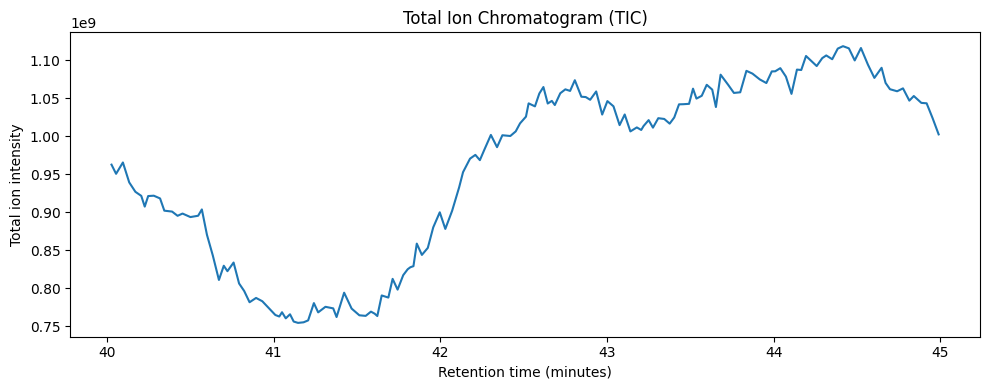

In [25]:
tic_rts = []
tic_intensities = []

for spec in exp:
  if spec.getMSLevel() == 1:
      rt = spec.getRT()
      mzs, ints = spec.get_peaks()

      total_intensity = np.sum(ints)  # sum of all intensities in this spectrum

      tic_rts.append(rt)
      tic_intensities.append(total_intensity)

tic_rts = np.array(tic_rts)
tic_intensities = np.array(tic_intensities)

plt.figure(figsize=(10, 4))
plt.plot(tic_rts / 60.0, tic_intensities)
plt.xlabel("Retention time (minutes)")
plt.ylabel("Total ion intensity")
plt.title("Total Ion Chromatogram (TIC)")
plt.tight_layout()
plt.show()

The TIC peaks indicate time regions where many ions (and thus analytes) elute.
Broad peaks can correspond to complex mixtures, sharp peaks to single analytes.

## Summary

Congratulations! You've completed the first notebook. You learned:

| Topic | Key Concept | pyOpenMS Tools |
|-------|-------------|----------------|
| **Protein digestion** | Trypsin cleaves after K/R (not before P) | `ProteaseDigestion`, `AASequence` |
| **MS data loading** | mzML files contain spectra with m/z and intensity | `MSExperiment`, `MzMLFile` |
| **2D visualization** | Peak maps show RT vs m/z with intensity as color | `get_peaks()`, matplotlib |
| **Isotope patterns** | Spacing = 1/charge; used to determine charge state | Interactive zoom |
| **TIC chromatogram** | Sum of intensities over time shows elution profile | `np.sum()` on peaks |

---

## Bonus Challenges

Test your understanding with these optional challenges:

<details>
<summary><b>Challenge 1 (Beginner): Try a Different Enzyme</b></summary>

Change the enzyme from Trypsin to another protease. Try:
- `"Chymotrypsin"` - cleaves after F, W, Y
- `"Lys-C"` - cleaves only after K
- `"Asp-N"` - cleaves before D

```python
digestion.setEnzyme("Chymotrypsin")  # Try this!
```

**Questions:**
1. How does the number of peptides change?
2. How does the average peptide length change?
3. Why might you choose one enzyme over another?

</details>

<details>
<summary><b>Challenge 2 (Intermediate): Find Another Isotope Pattern</b></summary>

Explore the spectrum to find a +3 charged ion:

1. Look for isotope peaks spaced ~0.33 m/z apart
2. Calculate the neutral mass
3. Compare: would this peptide be longer or shorter than our +2 example?

**Hint**: Higher charge states are often seen for larger peptides because they have more basic residues (K, R, H) to accept protons.

</details>

<details>
<summary><b>Challenge 3 (Advanced): Calculate Base Peak Chromatogram</b></summary>

Instead of TIC (sum of all intensities), calculate the **Base Peak Chromatogram (BPC)**:
- For each spectrum, record only the **maximum intensity peak**
- Plot max_intensity vs RT

```python
# Your code here - modify the TIC code
bpc_rts = []
bpc_intensities = []

for spec in exp:
    if spec.getMSLevel() == 1:
        rt = spec.getRT()
        mzs, ints = spec.get_peaks()
        max_intensity = ???  # What NumPy function gives the maximum?
        bpc_rts.append(rt)
        bpc_intensities.append(max_intensity)
```

**Question**: How does the BPC compare to the TIC? When might you prefer one over the other?

</details>

---

**Next up: [Notebook 2 - Peptide Identification](EUBIC_Task2_ID.ipynb)** - Learn how to identify which peptides produced the spectra you just visualized!